In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns
import pandas as pd
import requests
import os
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
from scipy.optimize import brentq
import scipy.stats as si
from scipy.stats import norm
import ast
from polygon import RESTClient
from polygon.rest.models.request import RequestOptionBuilder
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
from requests.exceptions import HTTPError
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
API_KEY = "HsOX1rl8t3B1AJfl4O2uqscUp372l7EF"
us_holidays = holidays.US(years=2024)
fila = 80

In [2]:
def next_working_day(date):
    date_obj = datetime.strptime(date, '%Y-%m-%d')
    next_day = date_obj + timedelta(days=1)
    while next_day.weekday() in (5, 6) or next_day in us_holidays:
        next_day += timedelta(days=1)
    return next_day.strftime('%Y-%m-%d')

def get_stock_price(date, expiration_day):
    url = f"https://api.polygon.io/v2/aggs/ticker/SPY/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    #print(url)  # For debugging purposes
    print(f"Trading Date:    {date}")
    print(f"Expiration Date: {expiration_day}")
    response = requests.get(url)

    if response.status_code == 200:
        try:
            data = response.json()
            if 'results' in data:
                return [(result['t'], result['c']) for result in data['results']]
            else:
                raise ValueError("Response JSON does not contain 'results' key")
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return []

def get_stock_data_for_date(date):
    expiration_day = next_working_day(date)
    option_data = get_stock_price(date, expiration_day)
    df = pd.DataFrame(option_data, columns=['timestamp', 'stock_price'])
    df['fecha'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df[df['fecha'].dt.time >= pd.to_datetime('13:30:00').time()]
    df['stock_price'] = round(df['stock_price'],2)
    df = df.reset_index(drop=True)
    return df

In [3]:
def get_option_price(ticker, date, expiration_day):
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/1/minute/{date}/{expiration_day}?adjusted=true&sort=asc&apiKey={API_KEY}"
    #print(url)
    response = requests.get(url)
    if response.status_code == 200:
        try:
            data = response.json()
            # Ensure 'results' key is present in the JSON response
            if 'results' in data:
                results = data['results']
                df_option = pd.DataFrame(results)
                
                # Check what columns are in df_option
                print(df_option.columns)
                
                # Rename columns if they exist
                if all(col in df_option.columns for col in ['o', 'c', 'l', 'h']):
                    df_option = df_option.rename(columns={
                        't': 'timestamp',
                        'o': 'open',
                        'c': 'close',
                        'l': 'low',
                        'h': 'high'
                    })
                    df_option['option_code'] = option_code
                    df_option['cum_return'] = 0
                    price_entry = df_option['close'].iloc[fila]
                    df_option.loc[fila:, 'cum_return'] = price_entry - df_option.loc[fila:, 'close']
                    df_option['option_type'] = option_type
                    return df_option[['timestamp', 'option_code', 'option_type', 'close','cum_return']]
        except ValueError as e:
            print(f"Error parsing JSON: {e}")
    else:
        print(f"Request failed with status code {response.status_code}")
    return None

In [4]:
def generate_ticker(df, fila, expiration_day):
    # Step 1: Format the expiration date
    expiration_day = expiration_day[2:].replace("-", "")

    # Step 2: Calculate the stock price values
    stock_price_value = round(df.iloc[fila]['stock_price'], 2)  # Use df instead of all_prices
    stock_price_value_ini = round(df.iloc[0]['stock_price'], 2)  # Use df instead of all_prices

    print(f"stock price al inicio sesión {stock_price_value_ini}")
    print(f"stock price en fila {fila}:      {stock_price_value}")

    # Step 3: Determine the option type and strike
    if stock_price_value >= stock_price_value_ini:
        option_type = 'P'
        print(f'Tenedencia Alcista-> Vender {option_type}')
        strike_entry = int(stock_price_value) - 4
    else:
        option_type = 'C'
        strike_entry = int(stock_price_value) + 4
        print(f'Tenedencia Bajista -> Vender {option_type}')

    # Step 4: Format the strike value
    strike_formatted = f"{strike_entry:05d}" + "000"  # Ensures strike is 8 digits with leading zeros, and appends "0000"

    # Step 5: Construct the final code
    option_code = f"O:SPY{expiration_day}{option_type}{strike_formatted}"
    print(option_code,'-',strike_entry)
    return option_code, option_type, strike_entry

In [5]:
def entradas_y_salidas_del_mercado(df, fila, option_type):
    # Assuming 'timestamp' should be used and converted to 'fecha'
    df['fecha'] = pd.to_datetime(df['timestamp'], unit='ms').dt.strftime('%Y-%m-%d')

    # Extract the first row's 'fecha' value
    fecha = df['fecha'].iloc[0]

    # Calculate required values
    stock_price = round(df.iloc[fila]['stock_price'], 2)
    price_entry = round(df_option.iloc[fila]['close'], 2)
    middle_index = len(df_option) // 2
    price_overnight = round(df_option.iloc[middle_index]['close'], 2)
    end_index = len(df_option) - 5
    price_end = round(df_option.iloc[end_index]['close'], 2)

    if option_type == 'C':
        max_min = df_option['close'].max()
    elif option_type == 'P':
        max_min = df_option['close'].min()
    else:
        raise ValueError("Invalid option_type. Please use 'C' for Call or 'P' for Put.")

    profit_overnight = abs(price_overnight - price_entry)
    profit_end = price_entry-price_end

    mae = df_option['cum_return'].min()
    mae_perc = round(mae/price_entry*100,0)
    return_ = round(profit_end/price_entry*100,0)
    if profit_end > 0:
        df_option['win_lose'] = 'win'
        win_lose = 'win'
    else:
        df_option['win_lose'] = 'lose'
        win_lose = 'lose'       
        
    # Create a dictionary with the summary data
    summary_data = {
        'fecha': fecha,
        'option': option_code,
        'type': option_type,
        'strike':strike_entry,
        'stock_entry': stock_price,
        'price_entry': price_entry,
        'price_overn': price_overnight,
        'price_end': price_end,
        'profit_overn': profit_overnight,
        'profit_end': profit_end,
        'return_%': return_,
        'win_lose': win_lose,
        'mae': mae,
        'mae_%': mae_perc
    }
    return summary_data

In [6]:
def plot_option_chart(df_option, fila, strike_entry, option_type, option_code):
    ovenight_index = int(len(df_option) / 2)
    end_index = len(df_option) - 2
    df_option['fecha'] = df_option['fecha'].astype(str)
    fig, (ax1, ax3) = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.04})
    ax2 = ax1.twinx()
    ax1.plot(df_option['fecha'], df_option['close'], color='green', label='Option', linewidth=2.0)
    ax2.plot(df_option['fecha'], df_option['stock_price'], color='blue', alpha=1.0, linewidth=0.8)
    ax1.set_ylabel('Prima', color='green')
    ax2.set_ylabel('Stock Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='green')
    ax2.tick_params(axis='y', labelcolor='blue')    
    ax1.yaxis.grid(True, alpha=0.6)
    ax1.xaxis.grid(False)
    ax1.tick_params(axis='x', which='both', length=0, labelbottom=False)    
    ax1.axvline(x=fila, color='grey', alpha=0.56, linestyle='-', linewidth=0.7)
    ax1.axvline(x=ovenight_index, color='grey', alpha=0.5, linestyle='-', linewidth=0.7)
    ax2.axhline(y=strike_entry, color='blue', alpha=0.5, linestyle='--')    
    ax1.plot(df_option['fecha'][fila], df_option['close'][fila], 'ko', markersize=9)
    ax1.plot(df_option['fecha'][ovenight_index], df_option['close'][ovenight_index], 'ro', markersize=9)
    ax1.plot(df_option['fecha'][end_index], df_option['close'][end_index], 'ro', markersize=9)    
    ax1.set_title(f'{option_code} - {option_type} {strike_entry}')
    ax3.fill_between(df_option['fecha'], df_option['cum_return'], where=(df_option['cum_return'] >= 0),
                     color='green', alpha=0.5, label='Beneficio')
    ax3.fill_between(df_option['fecha'], df_option['cum_return'], where=(df_option['cum_return'] < 0),
                     color='red', alpha=0.5, label='Pérdida')    
    ax3.set_ylabel('Beneficio Acumulado')
    ax3.tick_params(axis='y')    
    ax3.xaxis.set_major_locator(plt.MaxNLocator(10))
    for tick in ax3.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment('right')    
    ax3.yaxis.grid(True, alpha=0.6)
    ax3.xaxis.grid(False)    
    ax3.legend(loc='upper left')    
    output_dir = 'chart_output'
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'sell_the_swan_{timestamp}.png'
    output_path = os.path.join(output_dir, filename)
    plt.savefig(output_path)
    plt.show()

In [7]:
dates = ['2024-08-01','2024-08-06','2024-08-07','2024-08-08']

Trading Date:    2024-08-01
Expiration Date: 2024-08-02
stock price al inicio sesión 552.86
stock price en fila 80:      548.3
Tenedencia Bajista -> Vender C
O:SPY240802C00552000 - 552
Index(['v', 'vw', 'o', 'c', 'h', 'l', 't', 'n'], dtype='object')


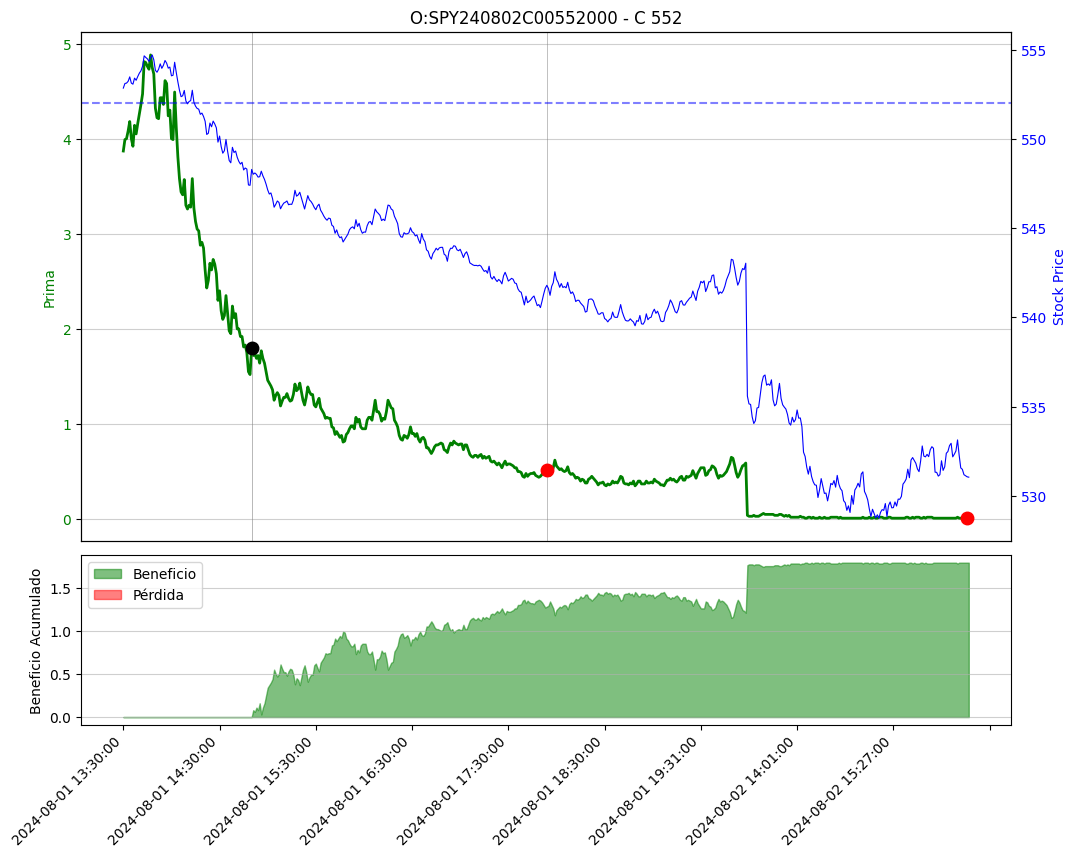

Trading Date:    2024-08-06
Expiration Date: 2024-08-07
stock price al inicio sesión 519.39
stock price en fila 80:      525.68
Tenedencia Alcista-> Vender P
O:SPY240807P00521000 - 521
Index(['v', 'vw', 'o', 'c', 'h', 'l', 't', 'n'], dtype='object')


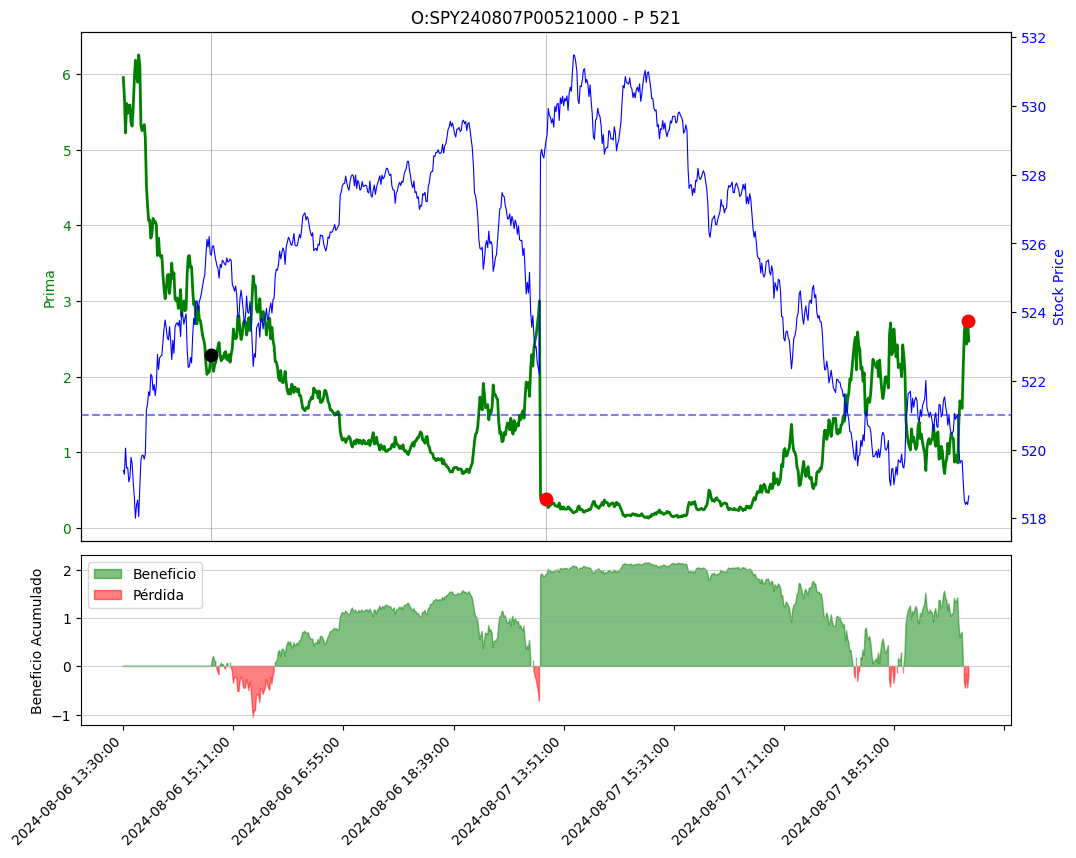

Trading Date:    2024-08-07
Expiration Date: 2024-08-08


In [ ]:
final_summary = pd.DataFrame()
for date in dates:
    df = get_stock_data_for_date(date)
    expiration_day = next_working_day(date)
    option_code, option_type, strike_entry = generate_ticker(df, fila, expiration_day)
    df_option = get_option_price(option_code, date, expiration_day)
    df_option = pd.merge(df_option, df, on='timestamp')
    summary = entradas_y_salidas_del_mercado(df, fila, option_type) 
    final_summary = final_summary.append(summary, ignore_index=True)
    plot_option_chart(df_option, fila, strike_entry, option_type, option_code)

In [ ]:
final_summary

In [ ]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'summary_{timestamp}.csv'
final_summary.to_csv(filename, index=False)

In [ ]:
# Calculate the required statistics
profit_overn_avg = round(final_summary['profit_overn'].mean(), 2)
profit_overn_max = round(final_summary['profit_overn'].max(), 2)
profit_overn_min = round(final_summary['profit_overn'].min(), 2)
profit_overn_sum = round(final_summary['profit_overn'].sum(), 2)
profit_end_avg = round(final_summary['profit_end'].mean(), 2)
profit_end_max = round(final_summary['profit_end'].max(), 2)
profit_end_min = round(final_summary['profit_end'].min(), 2)
profit_end_sum = round(final_summary['profit_end'].sum(), 2)
return_percent_avg = round(final_summary['return_%'].mean(), 2)
return_percent_max = round(final_summary['return_%'].max(), 2)
return_percent_min = round(final_summary['return_%'].min(), 2)
return_percent_sum = round(final_summary['return_%'].sum(), 2)
mae_avg = round(final_summary['mae'].mean(), 2)
mae_max = round(final_summary['mae'].max(), 2)
mae_min = round(final_summary['mae'].min(), 2)
mae_sum = round(final_summary['mae'].sum(), 2)

print("Profit Overnight:")
print(f"Average: {profit_overn_avg}")
print(f"Min: {profit_overn_min}")
print(f"Max: {profit_overn_max}")
print(f"Total Sum: {profit_overn_sum}\n")
print("Profit End:")
print(f"Average: {profit_end_avg}")
print(f"Min: {profit_end_min}")
print(f"Max: {profit_end_max}")
print(f"Total Sum: {profit_end_sum}\n")
print("Return %:")
print(f"Average: {return_percent_avg}")
print(f"Min: {return_percent_min}")
print(f"Max: {return_percent_max}")
print(f"Min: {return_percent_min}")
print(f"Total Sum: {return_percent_sum}\n")
print("MAE:")
print(f"Average: {mae_avg}")
print(f"Max: {mae_max}")
print(f"Min: {mae_min}")
print(f"Total Sum: {mae_sum}\n")

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(final_summary['profit_end'], color='green',bins=6)
plt.axvline(x=0, color='grey', alpha=0.6, linewidth=0.5)
plt.title('Retorno en  % at End')
plt.xlabel('retorno en  %')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(final_summary['profit_overn'], bins=6)
plt.axvline(x=0, color='grey', alpha=0.8, linewidth=0.7)
plt.title('Profit Overnight')
plt.xlabel('Prima')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(final_summary['return_%'], bins=6)
plt.axvline(x=0, color='grey', alpha=0.8, linewidth=0.7)
plt.title('Profit Overnight')
plt.xlabel('Prima')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(final_summary['mae'], color ='orange',bins=6)
plt.axvline(x=0, color='grey', alpha=0.8, linewidth=0.7)
plt.title('Maximum Adverse Excursion - MAE')
plt.xlabel('MAE - Prima')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x=final_summary['win_lose'], 
    y=final_summary['profit_end'],
    palette=(final_summary['profit_end'] > 0).map({True: 'green', False: 'red'})
)
plt.axhline(y=0, color='grey', alpha=0.9, linewidth=0.9)  # Horizontal line at 0
plt.title('Profit End by Win/Lose')
plt.xlabel('Win/Lose')
plt.ylabel('Profit End')
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting all rows on x-axis with profit_end on y-axis, and hue on win/lose
plt.figure(figsize=(14, 7))
sns.barplot(
    x=final_summary.index,  # Use the index for the x-axis to represent all rows
    y=final_summary['profit_end'],
    hue=final_summary['win_lose'],  # Color based on win/lose
    palette={'win': 'green', 'lose': 'red'}
)
plt.axhline(y=0, color='grey', alpha=0.9, linewidth=0.9)  # Horizontal line at 0
plt.title('Profit End Across All Rows with Win/Lose Hue')
plt.xlabel('Row Index')
plt.ylabel('Profit End')
plt.show()